# Notebook for RNN architectures

A.A. 2022-2023 - HUMAN DATA ANALYTICS

Authors:
* Mattia Brocco
* Brenda Eloisa Tellez Juarez

In [1]:
from google.colab import drive
drive.mount("/content/drive")

#%cd /content/drive/MyDrive/Environmental-sounds-UNIPD-2022

Mounted at /content/drive
/content/drive/MyDrive/Environmental-sounds-UNIPD-2022


In [2]:
import os
import sys
import torch
import librosa
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from librosa import display
from scipy.io import wavfile
from tensorflow import keras
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import evaluation
import CNN_support as cnns
from gng import GrowingNeuralGas

%load_ext autoreload
%autoreload 2

In [3]:
#reading the csv file
data = pd.read_csv('./data/meta/esc50.csv')
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
# Identify and select the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except:
    print("TPU not found")

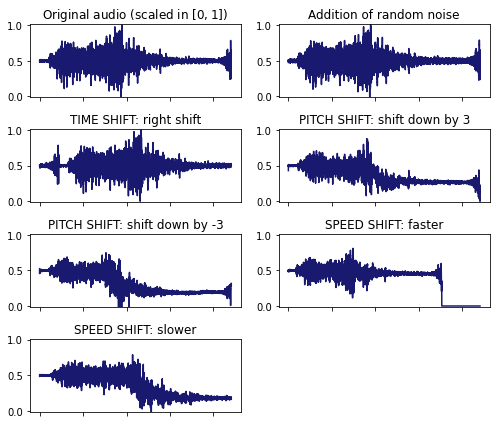

In [4]:
# Effects of augmentation

a, a_sr = librosa.load("./data/audio/{}".format(data.loc[120, "filename"]), sr = 44100)

fig_aug, ax_aug = plt.subplots(4, 2, figsize = (7, 6))

for i in range(8):
    row = i//2
    col = i%2

    scaled_a = (a - a.min())/(a.max() - a.min())
  
    if i == 0:
        plot_a = scaled_a
        aug_title = "Original audio (scaled in $[0, 1]$)"
    elif i == 1:
        plot_a = scaled_a + 0.005*np.random.randn(len( scaled_a ))
        aug_title = "Addition of random noise"
    elif i == 2:
        plot_a = np.roll(scaled_a, 22050)
        aug_title = "TIME SHIFT: right shift"
    elif i == 3:
        plot_a = librosa.effects.pitch_shift(y = scaled_a, sr = a_sr, n_steps = 3)
        aug_title = "PITCH SHIFT: shift down by 3"
    elif i == 4:
        plot_a = librosa.effects.pitch_shift(y = scaled_a, sr = a_sr, n_steps = -3)
        aug_title = "PITCH SHIFT: shift down by -3"
    elif i == 5:
        plot_a = librosa.effects.time_stretch(y = scaled_a, rate = 1.25)
        plot_a = np.append(plot_a, np.zeros(shape = len(scaled_a) - len(plot_a)))
        aug_title = "SPEED SHIFT: faster"
    elif i == 6:
        plot_a = librosa.effects.time_stretch(y = scaled_a, rate = 0.8)
        plot_a = plot_a[:len(scaled_a)]
        aug_title = "SPEED SHIFT: slower"
    else:
        ax_aug[row, col].set_visible(False)
  
    ax_aug[row, col].plot(plot_a, color = "#191970")
    ax_aug[row, col].set_xticklabels([])
    ax_aug[row, col].set_title(aug_title)
    ax_aug[row, col].set_ylim(-0.01, 1.01)
    

plt.tight_layout()
plt.show()
#plt.savefig("augmentation_effect.png", dpi = 300)

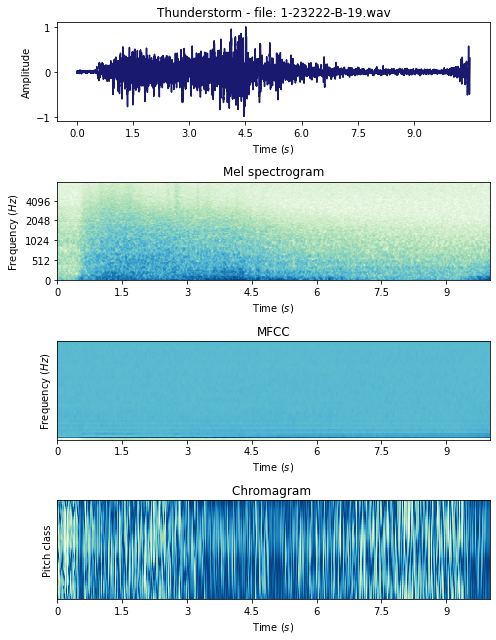

In [71]:
fig_eda, ax_eda = plt.subplots(4, 1, figsize = (7, 9))

# --------------------------------------------------------------------
librosa.display.specshow(librosa.power_to_db(
                          librosa.feature.melspectrogram(y = a, sr = a_sr,
                                                         n_mels = 128, fmax=8000),
                                   ref = np.max),
                               x_axis = "time", y_axis = "mel", fmax = 8000,
                               ax=ax_eda[1], cmap = "GnBu")
ax_eda[1].set_xlabel("Time $(s)$")
ax_eda[1].set_ylabel("Frequency $(Hz)$")
ax_eda[1].set_title("Mel spectrogram")
# --------------------------------------------------------------------
librosa.display.specshow(librosa.feature.mfcc(y = a, sr = a_sr,
                                 hop_length = 512, n_mfcc = 60),
            cmap = "GnBu", ax = ax_eda[2], x_axis = "time")
ax_eda[2].set_title("MFCC")
ax_eda[2].set_ylabel("Frequency $(Hz)$")
ax_eda[2].set_xlabel("Time $(s)$")
# --------------------------------------------------------------------
librosa.display.specshow(librosa.feature.chroma_stft(y = a, sr = a_sr,
                                        hop_length = 512, win_length = 1024,
                                        n_chroma = 60),
                         ax = ax_eda[3], cmap = "GnBu", y_axis='chroma', x_axis='time')
ax_eda[3].set_yticklabels([])
ax_eda[3].set_yticks([])
ax_eda[3].set_xlabel("Time $(s)$")
ax_eda[3].set_title("Chromagram ")
# --------------------------------------------------------------------
ax_eda[0].plot(np.linspace(ax_eda[3].get_xticks().min(),
                           ax_eda[3].get_xticks().max(),
                           len(a)), a, color = "#191970")
ax_eda[0].set_title("Thunderstorm - file: 1-23222-B-19.wav")
ax_eda[0].set_ylabel("Amplitude")
ax_eda[0].set_xlabel("Time $(s)$")
ax_eda[0].set_xticks(ax_eda[3].get_xticks()[:-1])


plt.tight_layout()
plt.show()
#plt.savefig("eda_image.jpg", dpi = 300)

Data import from `.parquet` files. The import is done only once then, depending on the desired input, the following `pd.DataFrame` is converted into a `np.array` and properly reshaped.

In [ ]:
X = pd.read_parquet(".//data/X_RNN_60x431_7times.parquet")
y = pd.read_parquet(".//data/y_RNN_7times.parquet")

## 1. RNN with 60x431 input (RNN-SEQ2D)

In [ ]:
X1 = X.values.reshape(len(X), 60, 431)
y1 = y.values

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size = .8,
                                                        random_state = 42, shuffle = True)
X_valid1, X_test1, y_valid1, y_test1 = train_test_split(X_test1, y_test1, train_size = .5,
                                                          random_state = 42, shuffle = True)

# one hot encoding of categories
y_train1 = tf.keras.utils.to_categorical(y_train1)
y_valid1 = tf.keras.utils.to_categorical(y_valid1)
y_test1 = tf.keras.utils.to_categorical(y_test1)

print("Training examples: {}".format(y_train1.shape[0]))
print("Validation examples: {}".format(y_valid1.shape[0]))
print("Test examples: {}".format(y_test1.shape[0]))
print()
print("Input shape: {}".format(X_train1[0].shape))

Training examples: 11200
Validation examples: 1400
Test examples: 1400

Input shape: (60, 431)


In [ ]:
BATCH_SIZE1 = 100

In [ ]:
with tpu_strategy.scope():
    null_model = keras.models.Sequential([keras.Input(shape = (60, 431)),
                                          keras.layers.Bidirectional(
                                              keras.layers.LSTM(int(431*3),
                                                                return_sequences = True)),
                                          keras.layers.Flatten(),
                                          keras.layers.Dense(400, activation = "relu"),
                                          keras.layers.Dropout(0.2),
                                          keras.layers.Dense(200, activation = "relu"),
                                          keras.layers.Dropout(0.2),
                                          keras.layers.Dense(100, activation = "relu"),
                                          keras.layers.Dropout(0.2),
                                          keras.layers.Dense(50, activation = "softmax")])
    
    null_model.compile(loss = "categorical_crossentropy",
                       optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                       metrics=["accuracy"])

print(null_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 60, 2586)         17843400  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 155160)            0         
                                                                 
 dense (Dense)               (None, 400)               62064400  
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                        

In [ ]:
nullHST = null_model.fit(X_train1, y_train1,
                         epochs = 100,
                         batch_size = BATCH_SIZE1,
                         validation_data = (X_valid1, y_valid1),
                         verbose = 0,
                         callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                    patience = 10)])


44/44 - 2s - loss: 1.1601 - accuracy: 0.7007 - 2s/epoch - 49ms/step
Accuracy on test: 70.07%
Memory used: 204.7 Mb


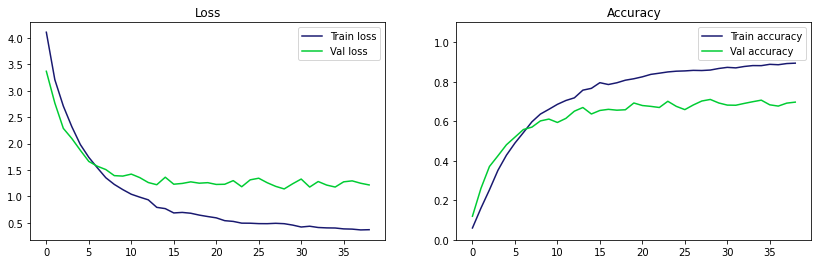

In [ ]:
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 4))
evaluation.plot_loss(nullHST, axis = ax1[0])
evaluation.plot_accuracy(nullHST, axis = ax1[1])
print()
scores_NULL1 = null_model.evaluate(X_test1, y_test1, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores_NULL1[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = null_model,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()
#plt.savefig("RNN-60x431.jpg", dpi = 300)

In the following cell a deeper analysis than the plain assessment of the accuracy on the test set is provided. In particular, we have been looking for the misclassified examples class of belonging and most common decepetion for those clasess.

In [ ]:
print("Less represented in test set")
print(data.loc[data["target"].isin([13, 46]), ["target", "category"]].drop_duplicates())
print()
print("More represented in test set")
print(data.loc[data["target"].isin([22, 49]), ["target", "category"]].drop_duplicates())

Less represented in test set
     target      category
33       46  church_bells
286      13      crickets

More represented in test set
    target  category
11      22  clapping
82      49  hand_saw


In [ ]:
data.loc[data["target"].isin([2, 5, 15, ]), ["target", "category"]].drop_duplicates()

In [ ]:
print(classification_report(y_test1.argmax(axis = 1),
                            null_model.predict(X_test1).argmax(axis = 1)))

44/44 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        35
           1       0.94      0.91      0.93        35
           2       0.65      0.73      0.69        33
           3       0.91      0.91      0.91        34
           4       0.85      0.79      0.82        29
           5       0.61      1.00      0.76        30
           6       0.73      0.56      0.63        34
           7       0.84      0.64      0.73        25
           8       0.80      0.71      0.75        28
           9       0.81      0.77      0.79        22
          10       0.49      0.71      0.58        24
          11       0.45      0.84      0.58        25
          12       0.44      0.70      0.54        30
          13       0.81      0.89      0.85        19
          14       0.76      0.71      0.73        31
          15       0.75      0.33      0.46        36
          16       0.76    

## 2. RNN with 1x431 input (RNN431)

In [ ]:
X2 = X.values.reshape(len(X), 60, 431).mean(axis = 1)
y2 = y.copy().values

X2 = X2.reshape(len(X2), 1, 431)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size = .8,
                                                        random_state = 42, shuffle = True)
X_valid2, X_test2, y_valid2, y_test2 = train_test_split(X_test2, y_test2, train_size = .5,
                                                          random_state = 42, shuffle = True)

# one hot encoding of categories
y_train2 = tf.keras.utils.to_categorical(y_train2)
y_valid2 = tf.keras.utils.to_categorical(y_valid2)
y_test2 = tf.keras.utils.to_categorical(y_test2)

print("Training examples: {}".format(y_train2.shape[0]))
print("Validation examples: {}".format(y_valid2.shape[0]))
print("Test examples: {}".format(y_test2.shape[0]))
print()
print("Input shape: {}".format(X_train2[0].shape))

Training examples: 11200
Validation examples: 1400
Test examples: 1400

Input shape: (1, 431)


In [ ]:
BATCH_SIZE1 = 100

In [ ]:
with tpu_strategy.scope():
    model2 = keras.models.Sequential([keras.Input(shape = (1, 431)),
                                      keras.layers.Bidirectional(
                                          keras.layers.GRU(int(431*3),
                                                           return_sequences = True)),
                                      keras.layers.Flatten(),
                                      keras.layers.Dense(400, activation = "relu"),
                                      keras.layers.Dropout(0.2),
                                      keras.layers.Dense(200, activation = "relu"),
                                      keras.layers.Dropout(0.2),
                                      keras.layers.Dense(100, activation = "relu"),
                                      keras.layers.Dropout(0.2),
                                      keras.layers.Dense(50, activation = "softmax")])
    
    model2.compile(loss = "categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                   metrics=["accuracy"])

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 1, 2586)          13390308  
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2586)              0         
                                                                 
 dense_4 (Dense)             (None, 400)               1034800   
                                                                 
 dropout_3 (Dropout)         (None, 400)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               80200     
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                      

In [ ]:
HST2 = model2.fit(X_train2, y_train2,
                  epochs = 100,
                  batch_size = BATCH_SIZE1,
                  validation_data = (X_valid2, y_valid2),
                  verbose = 0,
                  callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                             patience = 10)])


44/44 - 2s - loss: 3.0129 - accuracy: 0.2364 - 2s/epoch - 40ms/step
Accuracy on test: 23.64%
Memory used: 17.2 Mb


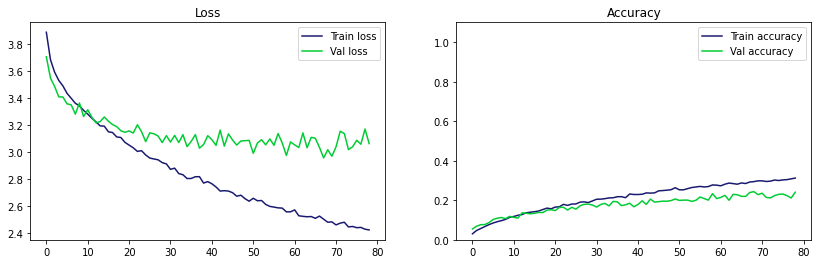

In [ ]:
fig2, ax2 = plt.subplots(1, 2, figsize = (14, 4))
evaluation.plot_loss(HST2, axis = ax2[0])
evaluation.plot_accuracy(HST2, axis = ax2[1])
print()
scores2 = model2.evaluate(X_test2, y_test2, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores2[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model2,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()
#plt.savefig("RNN-1x431.jpg", dpi = 300)

In [ ]:
print(classification_report(y_test2.argmax(axis = 1),
                            model2.predict(X_test2).argmax(axis = 1)))

44/44 [==============================] - 3s 31ms/step
              precision    recall  f1-score   support

           0       0.50      0.34      0.41        35
           1       0.50      0.49      0.49        35
           2       0.23      0.18      0.20        33
           3       0.24      0.15      0.18        34
           4       0.13      0.10      0.12        29
           5       0.27      0.20      0.23        30
           6       0.17      0.21      0.18        34
           7       0.12      0.08      0.10        25
           8       0.30      0.11      0.16        28
           9       0.50      0.05      0.08        22
          10       0.12      0.42      0.18        24
          11       0.06      0.08      0.07        25
          12       0.25      0.03      0.06        30
          13       0.19      0.32      0.24        19
          14       0.40      0.06      0.11        31
          15       0.46      0.17      0.24        36
          16       0.10    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model performs quite bad, so the analysis on misclassified examples was made only for the three classes that the model never predicts.

In [ ]:
# Model never predicts an example to be:
  # 40: helicopter -> mainly mistaken as train/rain/airplane
print(model2.predict(X_test2[np.where(y_test2.argmax(axis = 1) == 40)]).argmax(axis = 1), end = "\n\n")
  # 25: footsteps -> mainly mistaken as clapping but basically random
print(model2.predict(X_test2[np.where(y_test2.argmax(axis = 1) == 25)]).argmax(axis = 1), end = "\n\n")
  # 36: vacuum_cleaner -> mainly mistaken as rain/washing_machine
print(model2.predict(X_test2[np.where(y_test2.argmax(axis = 1) == 36)]).argmax(axis = 1), end = "\n\n")

1/1 [==============================] - 0s 475ms/step
[45 10 47 10 10 16 45 35 47 45 16 10 45 18 28 44 45 35 42  2 47 44 47 10
 16 35]

1/1 [==============================] - 0s 477ms/step
[16 22 27 30 19  2 46 47 22  4 38 37  4 13 19 38 45 45 12  1 37  5]

1/1 [==============================] - 0s 462ms/step
[11 44 47 18 35 10 11 35 18 35 47 45 35 10 10 10 35 35 10 44 10 35 47 45
 10 10 11 44]



## 3. RNN with 1x60 input

In [ ]:
X3 = X.values.reshape(len(X), 60, 431).mean(axis = 2)
y3 = y.copy().values
X3 = X3.reshape(len(X3), 1, 60)

#X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, train_size = .75,
#                                                        random_state = 42, shuffle = True)
#X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train3, y_train3, train_size = .8,
#                                                          random_state = 42, shuffle = True)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, train_size = .8,
                                                        random_state = 42, shuffle = True)
X_valid3, X_test3, y_valid3, y_test3 = train_test_split(X_test3, y_test3, train_size = .5,
                                                          random_state = 42, shuffle = True)

# one hot encoding of categories
y_train3 = tf.keras.utils.to_categorical(y_train3)
y_valid3 = tf.keras.utils.to_categorical(y_valid3)
y_test3 = tf.keras.utils.to_categorical(y_test3)

print("Training examples: {}".format(y_train3.shape[0]))
print("Validation examples: {}".format(y_valid3.shape[0]))
print("Test examples: {}".format(y_test3.shape[0]))
print()
print("Input shape: {}".format(X_train3[0].shape))

Training examples: 11200
Validation examples: 1400
Test examples: 1400

Input shape: (1, 60)


### RNN60-simple

In [ ]:
with tpu_strategy.scope():
    model3 = keras.models.Sequential([keras.Input(shape = (1, 60)),
                                      keras.layers.Bidirectional(keras.layers.GRU(1000,
                                                                                  return_sequences = True)),
                                      keras.layers.Flatten(),
                                      keras.layers.Dense(500, activation = "relu"),
                                      keras.layers.Dropout(0.2),
                                      keras.layers.Dense(200, activation = "relu"),
                                      keras.layers.Dropout(0.2),
                                      keras.layers.Dense(100, activation = "relu"),
                                      keras.layers.Dropout(0.2),
                                      keras.layers.Dense(50, activation = "softmax")])
    
    model3.compile(loss = "categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                   metrics=["accuracy"])

print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 2000)          6372000   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 500)               1000500   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                        

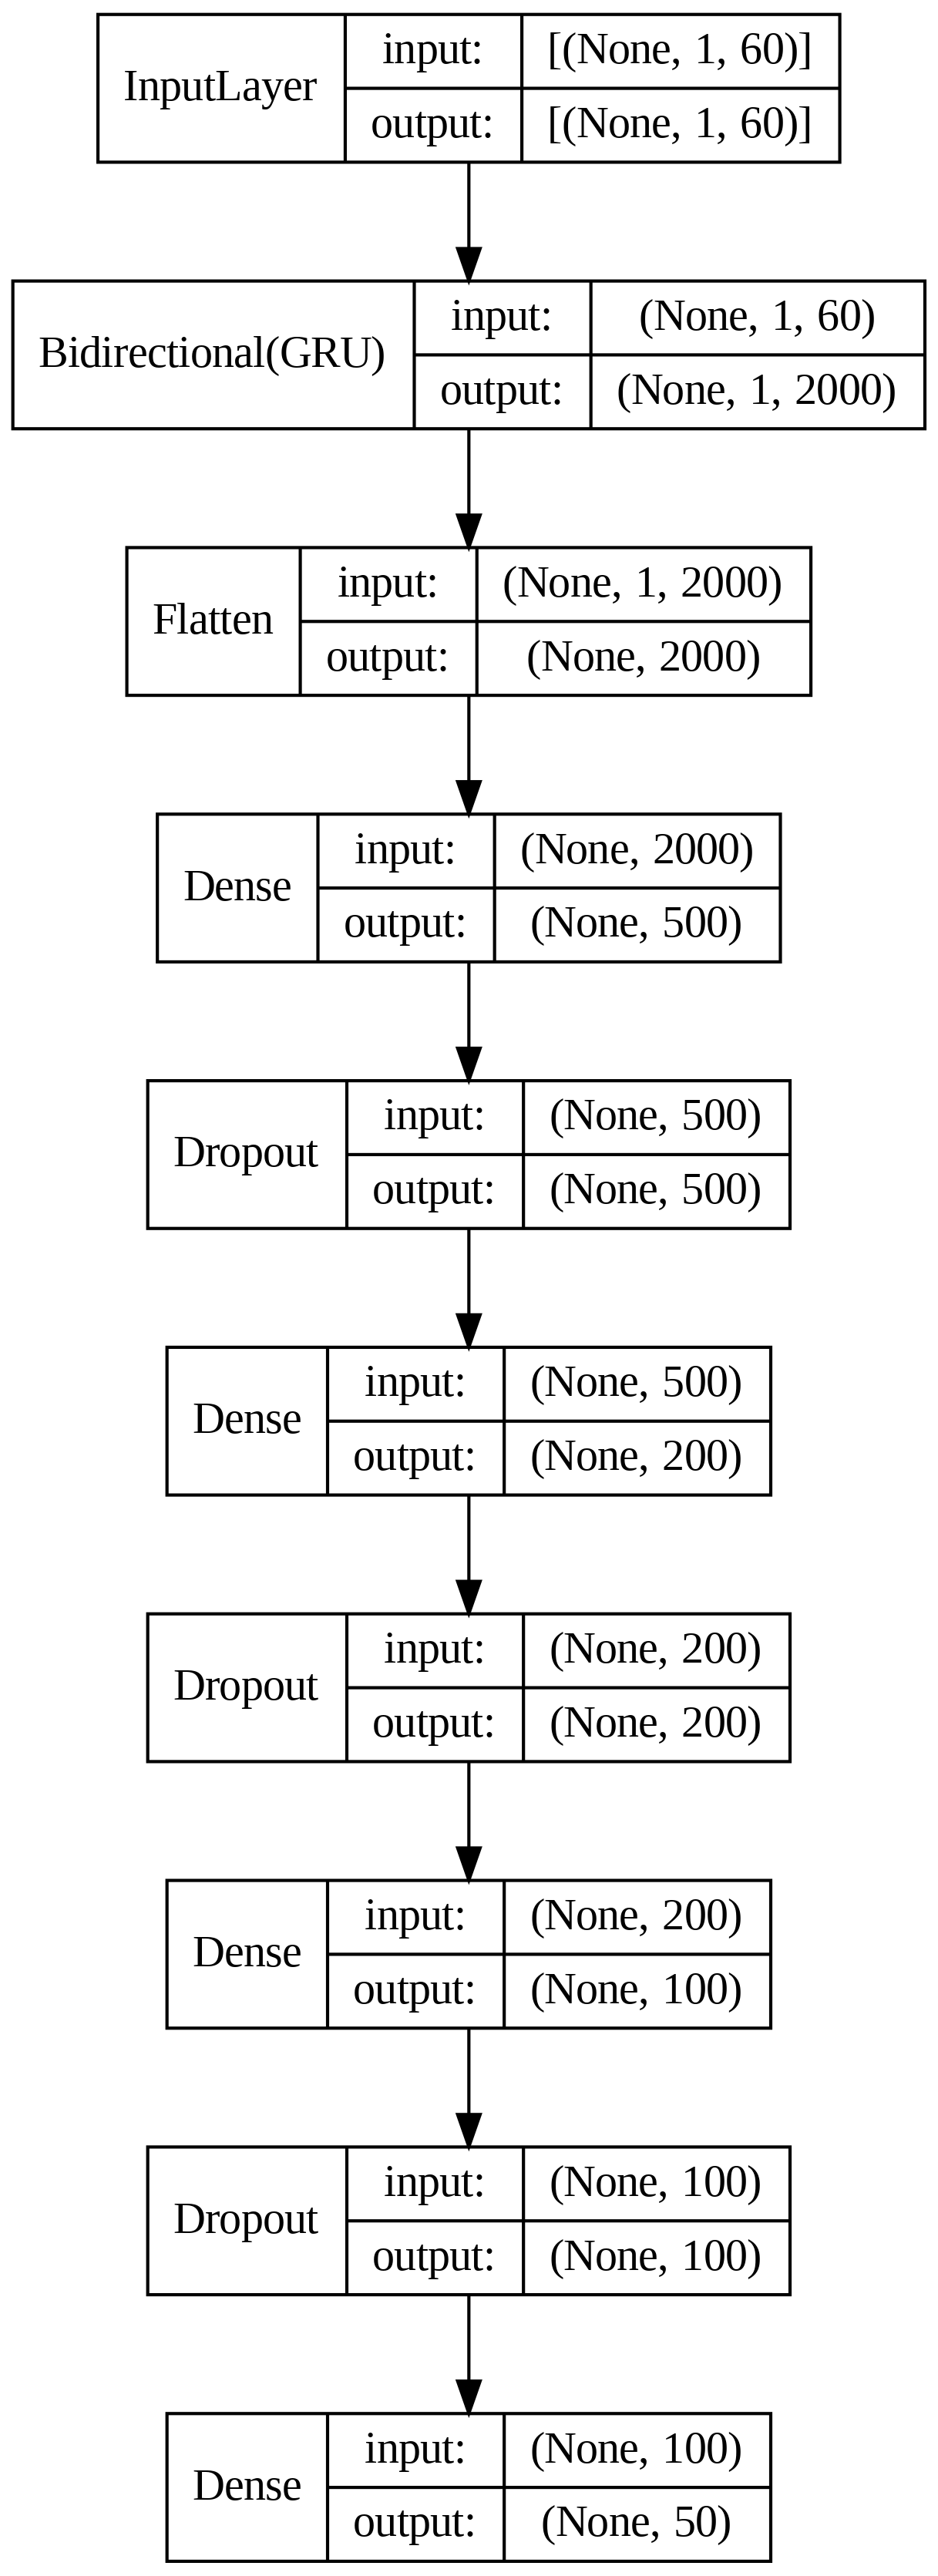

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model3, to_file = "RNN60-small-arch.png", show_shapes=True,
           show_layer_names=False, dpi = 300, show_layer_activations = False)

In [ ]:
BATCH_SIZE3 = 100

In [ ]:
HST3 = model3.fit(X_train3, y_train3,
                  epochs = 200,
                  batch_size = BATCH_SIZE3,
                  validation_data = (X_valid3, y_valid3),
                  verbose = 0,
                  callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                             patience = 10)])


44/44 - 1s - loss: 0.6021 - accuracy: 0.8600 - 729ms/epoch - 17ms/step
Accuracy on test: 86.00%
Memory used: 9.8 Mb


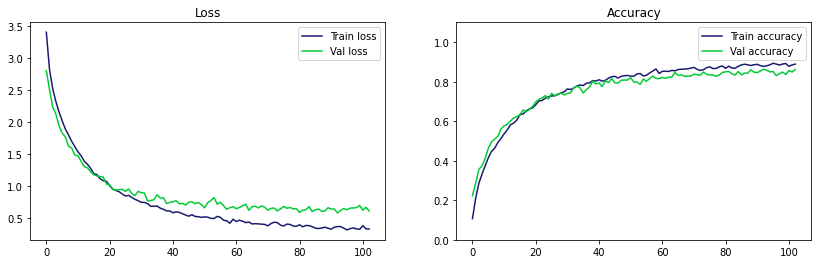

In [ ]:
fig3, ax3 = plt.subplots(1, 2, figsize = (14, 4))
evaluation.plot_loss(HST3, axis = ax3[0])
evaluation.plot_accuracy(HST3, axis = ax3[1])
print()
scores3 = model3.evaluate(X_test3, y_test3, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores3[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model3,
                                                     batch_size = BATCH_SIZE3)/1e6))

plt.show()
#plt.savefig("RNN-1x60_8M_params.jpg", dpi = 300)

In [ ]:
print(classification_report(y_test3.argmax(axis = 1),
                            model3.predict(X_test3).argmax(axis = 1)))

44/44 [==============================] - 3s 31ms/step
              precision    recall  f1-score   support

           0       0.80      0.94      0.87        35
           1       0.92      0.97      0.94        35
           2       0.85      0.85      0.85        33
           3       0.80      0.97      0.88        34
           4       0.93      0.90      0.91        29
           5       0.92      0.73      0.81        30
           6       0.83      0.85      0.84        34
           7       0.84      0.84      0.84        25
           8       0.86      0.89      0.88        28
           9       0.79      0.86      0.83        22
          10       0.76      0.92      0.83        24
          11       0.83      1.00      0.91        25
          12       1.00      0.73      0.85        30
          13       0.86      0.95      0.90        19
          14       0.93      0.81      0.86        31
          15       0.94      0.44      0.60        36
          16       0.88    

In [ ]:
# worst recall on 15 (water drops), 38 (clock tick), 39 (glass breaking)
print(model3.predict(X_test3[np.where(y_test3.argmax(axis = 1) == 15)]).argmax(axis = 1), end = "\n\n")

2/2 [==============================] - 1s 441ms/step
[13  4 38 15 31 15  4 37  6 38 38 34 26  4 15 24 38 38 34 39 13 49 34 34
 24 15 19 49 16  4 15  1 29 19 31 15]



### RNN60-LSTM

In [ ]:
# HUGE MODEL ON SAME DATA
with tpu_strategy.scope():
    # LSTM - complete with model definition, summary, fit and plots.
    model_bidirectional = keras.models.Sequential()
    model_bidirectional.add(keras.Input(shape = (1, 60)))
    model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(1024,
                                                                        return_sequences = True)))
    model_bidirectional.add(keras.layers.Dropout(0.2))
    model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(2048,
                                                                        return_sequences = True)))
    model_bidirectional.add(keras.layers.Dropout(0.2))
    model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(3036,
                                                                        return_sequences = False)))
    model_bidirectional.add(keras.layers.Dropout(0.2))  
    model_bidirectional.add(keras.layers.Flatten())         
    model_bidirectional.add(keras.layers.Dense(50, activation="softmax"))

    model_bidirectional.compile(loss = "categorical_crossentropy",
                                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                                metrics=["accuracy"])
    
print(model_bidirectional.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 1, 2048)          8888320   
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 1, 2048)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 4096)          67125248  
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 1, 4096)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 6072)             173246304 
 nal)                                                            
                                                      

In [ ]:
HST3huge = model_bidirectional.fit(X_train3, y_train3,
                                   epochs = 200,
                                   batch_size = BATCH_SIZE3,
                                   validation_data = (X_valid3, y_valid3),
                                   verbose = 0,
                                   callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                              patience = 10)])


44/44 - 1s - loss: 0.4229 - accuracy: 0.8950 - 986ms/epoch - 22ms/step
Accuracy on test: 89.50%
Memory used: 261.8 Mb


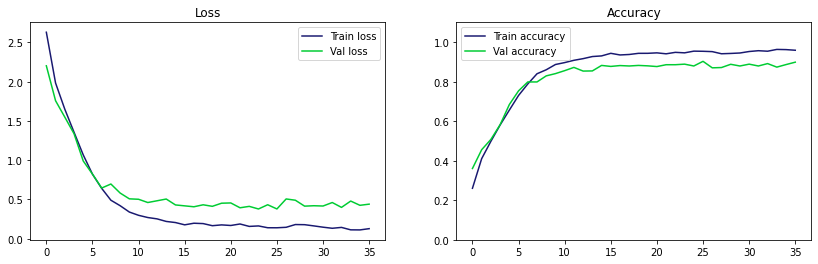

In [ ]:
fig4, ax4 = plt.subplots(1, 2, figsize = (14, 4))
evaluation.plot_loss(HST3huge, axis = ax4[0])
evaluation.plot_accuracy(HST3huge, axis = ax4[1])
print()
scores3huge = model_bidirectional.evaluate(X_test3, y_test3, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores3huge[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model_bidirectional,
                                                     batch_size = BATCH_SIZE3)/1e6))

plt.show()
#plt.savefig("RNN-1x60_250M_params.jpg", dpi = 300)

In [ ]:
print(classification_report(y_test3.argmax(axis = 1),
                            model_bidirectional.predict(X_test3).argmax(axis = 1)))

44/44 [==============================] - 5s 62ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        35
           1       0.92      0.97      0.94        35
           2       0.86      0.97      0.91        33
           3       0.92      0.97      0.94        34
           4       0.90      0.97      0.93        29
           5       0.88      0.77      0.82        30
           6       0.86      0.91      0.89        34
           7       0.68      0.84      0.75        25
           8       0.93      0.89      0.91        28
           9       0.87      0.91      0.89        22
          10       0.85      0.92      0.88        24
          11       0.93      1.00      0.96        25
          12       0.91      1.00      0.95        30
          13       0.95      0.95      0.95        19
          14       0.91      0.94      0.92        31
          15       0.97      0.83      0.90        36
          16       0.93    

### RNN60-GRU

In [ ]:
with tpu_strategy.scope():
    #Considering the GRU layer
    model_bidirectional2 = keras.models.Sequential()
    model_bidirectional2.add(keras.Input(shape = (1, 60)))
    model_bidirectional2.add(keras.layers.GRU(256, return_sequences = True))
    model_bidirectional2.add(keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences = True)))
    model_bidirectional2.add(keras.layers.Dropout(0.2))
    model_bidirectional2.add(keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences = True)))
    model_bidirectional2.add(keras.layers.Dropout(0.2))
    model_bidirectional2.add(keras.layers.GRU(512, return_sequences = False))
    model_bidirectional2.add(keras.layers.Dropout(0.2))  
    model_bidirectional2.add(keras.layers.Flatten())         
    model_bidirectional2.add(keras.layers.Dense(50, activation="softmax"))

    model_bidirectional2.compile(loss = "categorical_crossentropy",
                                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                 metrics = ["accuracy"])
    
print(model_bidirectional2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 1, 256)            244224    
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 2048)          10493952  
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 1, 2048)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 4096)          67125248  
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1, 4096)           0         
                                                                 
 gru_2 (GRU)                 (None, 512)              

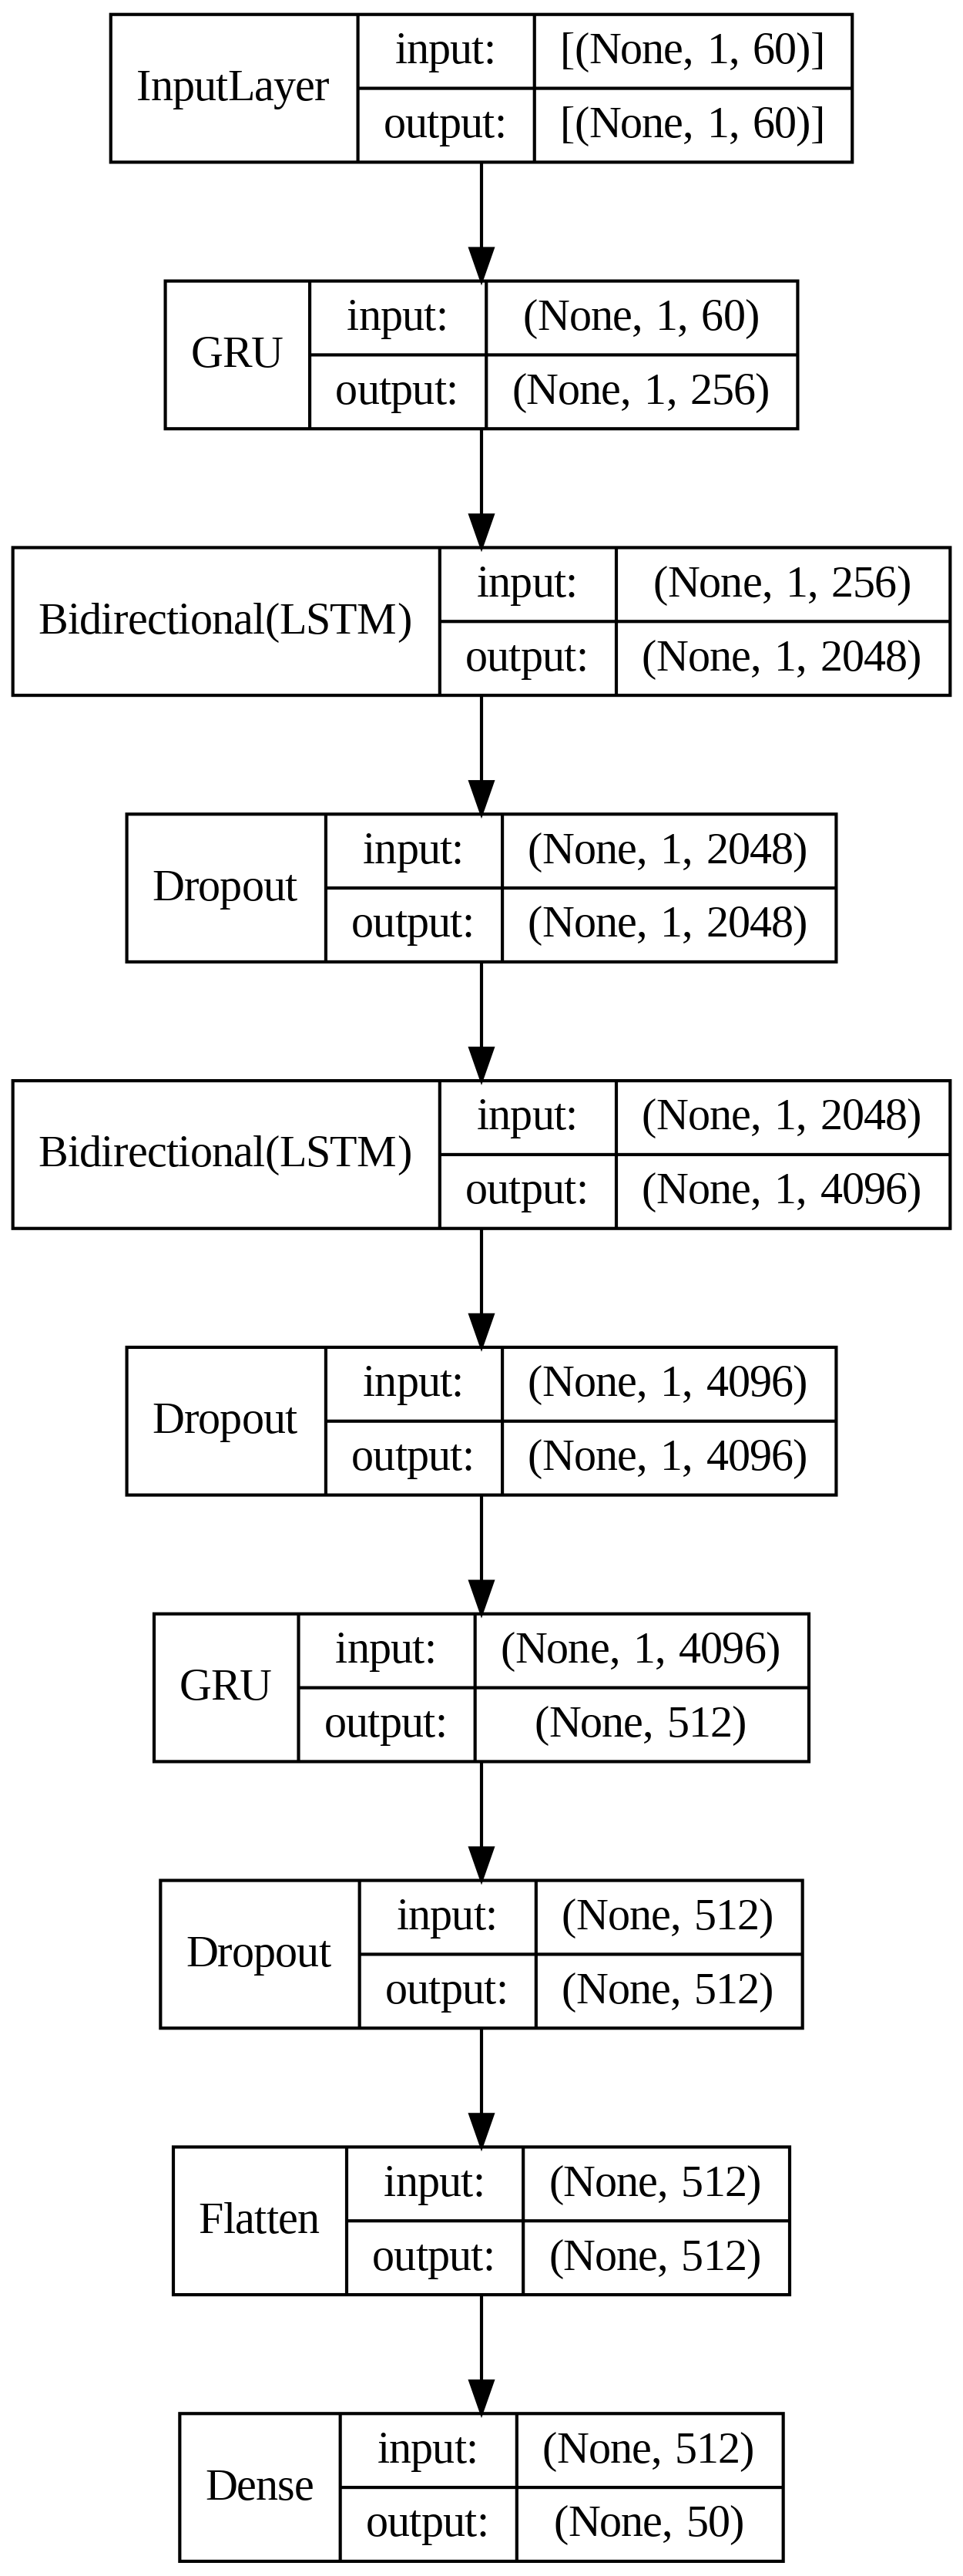

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model_bidirectional2, to_file = "RNN60-GRU-arch.png", show_shapes=True,
           show_layer_names=False, dpi = 300, show_layer_activations = False)

In [ ]:
HST4huge = model_bidirectional2.fit(X_train3, y_train3,
                                    epochs = 200,
                                    batch_size = BATCH_SIZE3,
                                    validation_data = (X_valid3, y_valid3),
                                    verbose = 0,
                                    callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                               patience = 10)])


44/44 - 1s - loss: 0.4092 - accuracy: 0.8814 - 813ms/epoch - 18ms/step
Accuracy on test: 88.14%
Memory used: 90.6 Mb


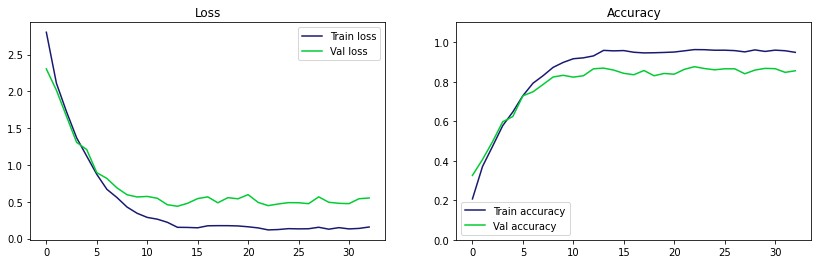

In [ ]:
fig5, ax5 = plt.subplots(1, 2, figsize = (14, 4))
evaluation.plot_loss(HST4huge, axis = ax5[0])
evaluation.plot_accuracy(HST4huge, axis = ax5[1])
print()
scores4 = model_bidirectional2.evaluate(X_test3, y_test3, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores4[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model_bidirectional2,
                                                     batch_size = BATCH_SIZE3)/1e6))

plt.show()
#plt.savefig("RNN-1x60_GRU_85M_params.jpg", dpi = 300)

In [ ]:
print(classification_report(y_test3.argmax(axis = 1),
                            model_bidirectional2.predict(X_test3).argmax(axis = 1)))

In [ ]:
#saving the model
#from keras.models import save_model

#save_model(model_bidirectional2, "model_bidirectional2.h5")

---
---
---